In [ ]:
# Don't blame me
#           -Kai
#
# github.com/kaibrooks

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
# use tensorflow and keras as a high-level api to make it faster to get something running
import tensorflow as tf
import threading
import scipy
import PIL # this imports Pillow, but for some dumb reason needs 'PIL'
from PIL import Image
from tensorflow import keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from datetime import datetime # so we know how much time we've wasted

import numpy as np
import matplotlib.pyplot as plt # plot things

import os

# might be good to know

print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
print('Pillow version', PIL.__version__) 


try:
  # %tensorflow_version only exists in google colab, see if we can use it or not
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
## all the settings, this section is the secret sauce
# hyperparameters
batch_size = 16  # 16?
num_classes = 3 # how many classes we're detecting
epochs = 4 # 100
num_predictions = 20 # 20
learning_rate = 0.0001 #0.0001
decay = 1e-6 # 1e-6
imSize = 256 # 256, resize images for training

# sub-parameters
use_multiprocessing = False # F parallelize or not
workers = 1 # 1 workers to use for training

# other settings
data_augmentation = False # T make permutations to train better
threadSafe = False # F make thread safe, sometimes produces errors
fastTrain = False # F 3x less time, 0.75x as accurate ish

# output
save_dir = os.path.join(os.getcwd(), 'trained_models')
#model_name = 'keras_trained_model_' + now.strftime("%d-%b-%Y_%H:%M:%S") + '.h5' # this is below


In [ ]:
## load the data

print('Getting data from', os.getcwd())
datagen = ImageDataGenerator(rescale = 1. / 255) # rescale images to squares for display

# load and iterate training dataset
print('Train: ')
train_it = datagen.flow_from_directory('data/train/', class_mode='categorical', batch_size=batch_size, target_size=(imSize, imSize))

# load and iterate validation dataset
print('Validate: ')
val_it = datagen.flow_from_directory('data/validation/', class_mode='categorical', batch_size=batch_size, target_size=(imSize, imSize))

# load and iterate test dataset
print('Test:')
test_it = datagen.flow_from_directory('data/test/', class_mode='categorical', batch_size=batch_size)

In [ ]:
## display the training images
# if this is incorrect in any way, some training images are in the wrong folder
class_names = ['blue','cheese','pink']
(train_images, train_labels) = train_it.next()
plt.figure(figsize=(15,15))
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])]) # int because class number is normally a float
    #plt.xlabel(train_labels[i])
plt.show()
print('We\'re almost at the training step. If this image must be 100% correct')

In [26]:
## this area is actually the other half of the secret sauce
# set up model
# dropout 50% for hidden and 20% for visible?

if fastTrain:
    print('Using fast training algorithm, model will be less accurate')
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes)) # convergence layer
    model.add(Activation('softmax'))
    
elif not fastTrain:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=train_images.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes)) # convergence layer
    model.add(Activation('softmax'))

print('Model in the chamber:', model)
print('--- Ready to train ---')

Using fast training algorithm, model will be less accurate
Model in the chamber: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7feae0897c18>


ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [23]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=learning_rate, decay=decay)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this takes

# fit model
model.fit_generator(train_it, 
                    epochs=epochs, 
#                    steps_per_epoch=16, 
                    validation_data=val_it, 
                    validation_steps=8,
                    workers=workers)


(x_test, y_test) = val_it.next()
# Fit the model on the batches generated by datagen.flow().
#model.fit_generator(datagen.flow(train_images, train_labels,
#                    batch_size=batch_size),
#                    epochs=epochs,
#                    validation_data=(x_test, y_test),
#                    use_multiprocessing=use_multiprocessing,
#                    max_queue_size=10,
#                    workers=workers) # workers = 1 or 4?



then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 27-Nov-2019 03:15:23
Epoch 1/4
80/80 [==============================] - 79s 990ms/step - loss: 10.9199 - accuracy: 0.2940 - val_loss: 11.0812 - val_accuracy: 0.3125
Epoch 2/4
80/80 [==============================] - 78s 973ms/step - loss: 11.0812 - accuracy: 0.3321 - val_loss: 11.0812 - val_accuracy: 0.3125
Epoch 3/4
80/80 [==============================] - 77s 961ms/step - loss: 11.0812 - accuracy: 0.2936 - val_loss: 11.0812 - val_accuracy: 0.3125
Epoch 4/4
80/80 [==============================] - 76s 952ms/step - loss: 11.0812 - accuracy: 0.3246 - val_loss: 11.0812 - val_accuracy: 0.3125
Finished training at 27-Nov-2019 03:20:34
Model summary:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple  

In [27]:
## output
# save model and weights
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel' + '.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)
size = os.path.getsize(model_path)
print('Model is',round(size/1e+6),'MB')

# save model log
filename = 'trained_models/' + now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'

with open(filename,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

ValueError: Weights for model sequential_5 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [28]:
# Score trained model
(test_images, test_labels) = test_it.next()
scores = model.evaluate(test_images, test_labels, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

16/1 - 0s - loss: 1.1077 - accuracy: 0.3750
Test loss: 1.1076667308807373
Test accuracy: 0.375


In [29]:
## make a predictions
predictions = model.predict(test_images) # load the data
predictions[0] # predict the [0]th element, this outputs an array with each element being the confidence of being that class
print('Class confidence for image 0:', predictions[0])
print('\nPrediction  :', np.argmax(predictions[0])) # output the most likely prediction
print('Actual class:', np.argmax(test_labels))  # output what the answer actually is)

Class confidence for image 0: [0.21504748 0.5943277  0.19062477]

Prediction  : 1
Actual class: 0


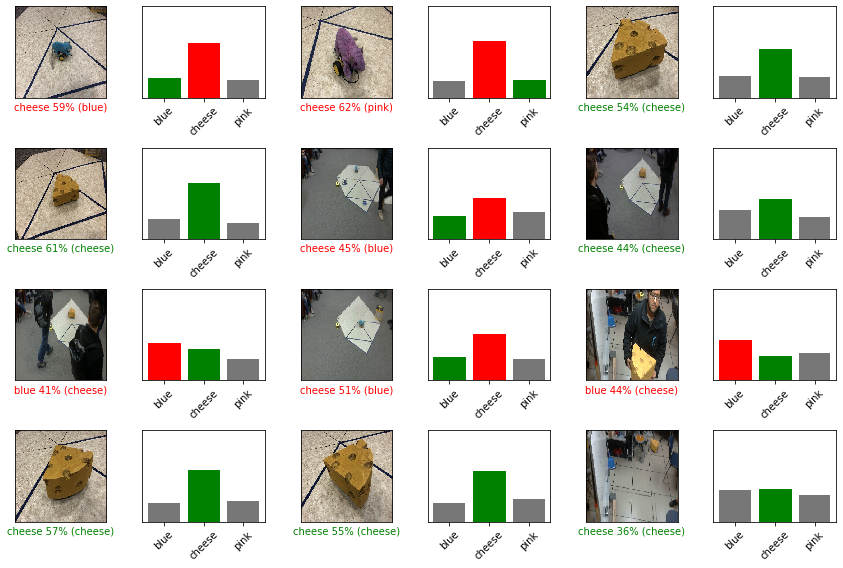

In [30]:
## make a pinterest board of images and their classifications
# set up first
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('green')

## plot a single image and its prediction
#i = 0
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

# lets do another
#i = 12
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

## show a bunch of predicted images and display a grid
num_rows = 4 # increase this to show more
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
  _ = plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.tight_layout()
plt.show()